# Import Libraries

In [1]:
# Load libraries
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
set_option('display.max_rows', 500)
set_option('display.max_columns', 500)
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime
import pyodbc
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import roc_auc_score,roc_curve
from pickle import dump
from pickle import load
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Connect to SQL Server

In [2]:
pyodbc.drivers()

['SQL Server', 'ODBC Driver 17 for SQL Server']

In [3]:
connection = pyodbc.connect(
"Driver={ODBC Driver 17 for SQL Server};"
"Server=DESKTOP-ROTIMI\SQLEXPRESS;"
"Database=Rossmann;"
"Trusted_Connection=yes;")

# load dataset

#### Extracting data from SQL Server

In [4]:
# View data from SQL Server
storedf = pd.read_sql("Select * from [dbo].[store_cleaned]",connection)
traindf = pd.read_sql("Select * from [dbo].[train_cleaned]",connection)
testdf = pd.read_sql("Select * from [dbo].[test_cleaned]",connection)

# Storedf Table

#### View Data

In [5]:
# head
storedf.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_Int,Assortment_Int,PromoInterval_int
0,1,c,a,1270,9,2008,0,0,0,period 0,3,1,0
1,2,a,a,570,11,2007,1,13,2010,Period 1,1,1,1
2,3,a,a,14130,12,2006,1,14,2011,Period 1,1,1,1
3,4,c,c,620,9,2009,0,0,0,period 0,3,3,0
4,5,a,a,29910,4,2015,0,0,0,period 0,1,1,0


#### shape of the data

In [6]:
# shape
print(storedf.shape)


(1115, 13)


#### types of the data column

In [7]:
# types
print(storedf.dtypes)


Store                         int64
StoreType                    object
Assortment                   object
CompetitionDistance           int64
CompetitionOpenSinceMonth     int64
CompetitionOpenSinceYear      int64
Promo2                        int64
Promo2SinceWeek               int64
Promo2SinceYear               int64
PromoInterval                object
StoreType_Int                 int64
Assortment_Int                int64
PromoInterval_int             int64
dtype: object


#### data descriptions

In [8]:
# descriptions
storedf.describe()


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_Int,Assortment_Int,PromoInterval_int
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5404.898655,4.930942,1370.939013,0.512108,12.083408,1030.239462,2.217040,1.928251,0.818834
std,322.01708,7652.849306,4.284924,935.467654,0.500078,15.542241,1006.038782,1.369544,0.993814,0.976108
min,1.00000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,279.50000,720.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,558.00000,2330.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000,1.000000,1.000000,1.000000
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000,4.000000,3.000000,1.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,4.000000,3.000000,3.000000


#### data descriptions

In [9]:
# descriptions
storedf.describe(include = 'object')


,StoreType,Assortment,PromoInterval
count,1115,1115,1115
unique,4,3,4
top,a,a,period 0
freq,602,593,544


#### Check for missing entries

In [10]:
# Check for missing entries
total = storedf.isnull().sum().sort_values(ascending=False)
percent=(storedf.isnull().sum()*100/len(storedf)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Store,0,0.0
StoreType,0,0.0
Assortment,0,0.0
CompetitionDistance,0,0.0
CompetitionOpenSinceMonth,0,0.0
CompetitionOpenSinceYear,0,0.0
Promo2,0,0.0
Promo2SinceWeek,0,0.0
Promo2SinceYear,0,0.0
PromoInterval,0,0.0


In [11]:
# Encoding category to numeric
le = LabelEncoder()
storedf['StoreType_01'] = le.fit_transform(storedf['StoreType'])
storedf['Assortment_01'] = le.fit_transform(storedf['Assortment'])

##### Change type 32int to 64int

In [12]:
storedf['StoreType_01'] = storedf['StoreType_01'].astype('int64')
storedf['Assortment_01'] = storedf['StoreType_01'].astype('int64')

#### Check for duplicate data

In [13]:
# locate rows of duplicate data

# calculate duplicates
dups = storedf.duplicated()
# report if there are any duplicates
print(dups.any())


False


#### Correlation 

In [14]:
storedf_corr = storedf.select_dtypes(include=['int64']).copy()
# correlation
storedf_corr.corr(method='pearson')

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_Int,Assortment_Int,PromoInterval_int,StoreType_01,Assortment_01
Store,1.000000,-0.027199,-0.030084,-0.005498,0.007486,0.009264,0.007521,-0.020977,0.003913,-0.001257,-0.020977,-0.020977
CompetitionDistance,-0.027199,1.000000,-0.032557,-0.002179,-0.145517,-0.130307,-0.145582,0.080033,0.144636,-0.123788,0.080033,0.080033
CompetitionOpenSinceMonth,-0.030084,-0.032557,1.000000,0.785030,-0.080671,-0.106586,-0.080591,-0.038439,-0.096024,-0.068024,-0.038439,-0.038439
CompetitionOpenSinceYear,-0.005498,-0.002179,0.785030,1.000000,-0.095603,-0.120918,-0.095526,-0.064847,-0.122689,-0.118930,-0.064847,-0.064847
Promo2,0.007486,-0.145517,-0.080671,-0.095603,1.000000,0.759193,0.999999,0.086597,-0.000057,0.819170,0.086597,0.086597
Promo2SinceWeek,0.009264,-0.130307,-0.106586,-0.120918,0.759193,1.000000,0.759023,0.055533,-0.038318,0.618142,0.055533,0.055533
Promo2SinceYear,0.007521,-0.145582,-0.080591,-0.095526,0.999999,0.759023,1.000000,0.086534,-0.000017,0.819231,0.086534,0.086534
StoreType_Int,-0.020977,0.080033,-0.038439,-0.064847,0.086597,0.055533,0.086534,1.000000,0.234372,0.092560,1.000000,1.000000
Assortment_Int,0.003913,0.144636,-0.096024,-0.122689,-0.000057,-0.038318,-0.000017,0.234372,1.000000,0.038409,0.234372,0.234372
PromoInterval_int,-0.001257,-0.123788,-0.068024,-0.118930,0.819170,0.618142,0.819231,0.092560,0.038409,1.000000,0.092560,0.092560


#### Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix(for dataset)')

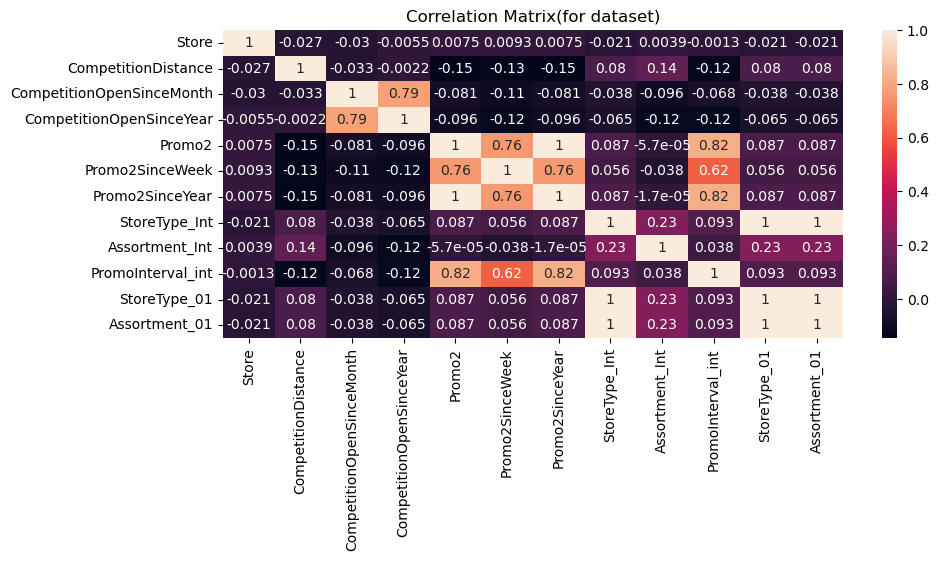

In [15]:
# Correlation 
plt.figure(figsize=(10,4))
sns.heatmap(storedf_corr.corr(),annot=True)
plt.title("Correlation Matrix(for dataset)")

- **Note**
   1. The correlation between Promo2 and Promo2sinceweek is 0.76
   2. The correlation between Promo2 and Promo2sinceYear is high (Multicollinearity) which is 1.00 (they share the same information).<br>
      one of the column need to drop.
   3. CompetitionOpenSinceMonth and CompetitionOpenSinceYear have a correlation of 0.79 <br>
      They share similar information (One of the column should be retained).
   4. There is high correlation between StoreType_01 and Assortment_01

- **Action**
   1. Promo2sinceYear will be drop
   2. CompetitionOpenSinceMonth provide more information , CompetitionOpenSinceYear will be drop
   3. Both StoreType_01 and Assortment_01 Share the same information, Both or one should be drop

#### VIF : Checking for Multicollinearity

In [16]:

X = storedf[['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear','StoreType_01','Assortment_01']]

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                     Feature           VIF
0                      Store  2.634904e+00
1        CompetitionDistance  1.431755e+00
2  CompetitionOpenSinceMonth  6.088575e+00
3   CompetitionOpenSinceYear  7.488419e+00
4                     Promo2  1.533388e+06
5            Promo2SinceWeek  3.995663e+00
6            Promo2SinceYear  1.532475e+06
7               StoreType_01           inf
8              Assortment_01           inf


#### Removal of Redundant Column 

In [17]:
# Removal of redundant column and also with high multicollinearity
columns = ['Promo2SinceYear','CompetitionOpenSinceYear','PromoInterval','Assortment','Assortment_01']
storedf.drop(columns,axis=1,inplace=True)

#### Scatter Plot

Text(0, 0.5, 'Sales')

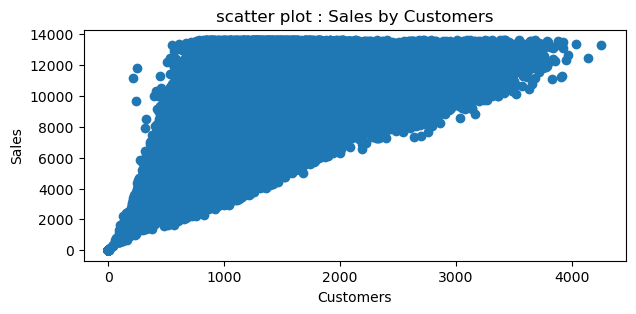

In [18]:
plt.figure(figsize=(7,3))
plt.title('scatter plot : Sales by Customers')
plt.scatter(data = traindf,x = 'Customers',y = 'Sales')
plt.xlabel('Customers')
plt.ylabel('Sales')


#### Histogram

Text(0, 0.5, 'Sales')

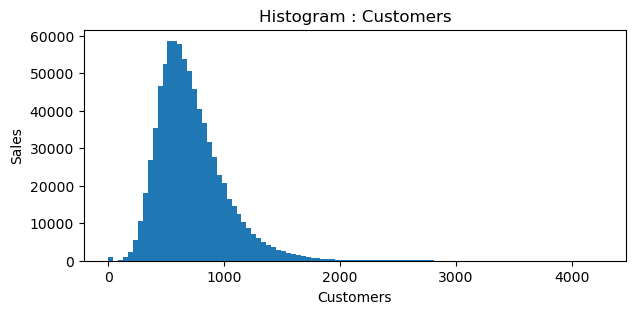

In [19]:
plt.figure(figsize=(7,3))
plt.title('Histogram : Customers')
plt.hist(data = traindf,x = 'Customers',bins = 100)
plt.xlabel('Customers')
plt.ylabel('Sales')


# Traindf Table

#### view data

In [20]:
# head
traindf.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,5,5,2015-07-31,4822,559,1,1,0,1
4,6,5,2015-07-31,5651,589,1,1,0,1


#### shape of the data

In [21]:
# shape
print(traindf.shape)

(814299, 9)


#### types of column

In [22]:
# types
print(traindf.dtypes)


Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object


#### data description

In [23]:
# descriptions
traindf.describe()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000
mean,557.386423,3.546504,6578.110456,718.145233,0.999000,0.435819,0.000996,0.192362
std,323.195128,1.714786,2429.153669,306.621660,0.031601,0.495864,0.031543,0.394156
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,277.000000,2.000000,4798.000000,513.000000,1.000000,0.000000,0.000000,0.000000
50%,557.000000,4.000000,6250.000000,663.000000,1.000000,0.000000,0.000000,0.000000
75%,840.000000,5.000000,8078.000000,861.000000,1.000000,1.000000,0.000000,0.000000
max,1115.000000,7.000000,13610.000000,4256.000000,1.000000,1.000000,1.000000,1.000000


#### Check for missing entries

In [24]:
# Check for missing entries
total = traindf.isnull().sum().sort_values(ascending=False)
percent=(traindf.isnull().sum()*100/len(traindf)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Sales,0,0.0
Customers,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0


#### Check for duplicate rows

In [25]:
# locate rows of duplicate data

# calculate duplicates
dups = traindf.duplicated()
# report if there are any duplicates
print(dups.any())


False


# Feature Engineering

#### conversion to datetime

In [26]:
traindf['Date'] = pd.to_datetime(traindf['Date'])


#### Create time-based features

In [27]:
# Create time-based features
traindf["Year"] = traindf["Date"].dt.year
traindf["Month"] = traindf["Date"].dt.month
traindf["WeekOfYear"] = traindf["Date"].dt.isocalendar().week
traindf["IsWeekend"] = traindf["DayOfWeek"].apply(lambda x: 1 if x >= 5 else 0)  # 1 = Weekend
traindf["Season"] = traindf["Month"].map({1: "winter", 2: "winter", 3: "spring", 4: "spring", 5: "spring", 6: "summer", 7: "summer", 8: "summer", 9: "fall", 10: "fall", 11: "fall", 12: "winter"})


#### Extract text-based details

In [28]:
# Extract text-based details
traindf['Month_01'] = traindf['Date'].dt.strftime('%B')  # Full month name
traindf['Day'] = traindf['Date'].dt.strftime('%d')    # Day as text
traindf['Day of Week'] = traindf['Date'].dt.strftime('%A')  # Full weekday name

#### Lag Features (Past Sales Trends)

In [29]:
traindf["Sales_Lag_7"] = traindf.groupby("Store")["Sales"].shift(7)
traindf["Sales_Lag_7"]


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
814294     5775.0
814295    12577.0
814296     7659.0
814297     4260.0
814298     8057.0
Name: Sales_Lag_7, Length: 814299, dtype: float64

In [30]:
traindf["Sales_Lag_30"] = traindf.groupby("Store")["Sales"].shift(30)
traindf["Sales_Lag_30"]

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
814294    11235.0
814295    11807.0
814296     9244.0
814297     5405.0
814298     9390.0
Name: Sales_Lag_30, Length: 814299, dtype: float64

#### Rolling Mean for Trend Analysis

In [31]:
traindf["Sales_MA_7"] = traindf.groupby("Store")["Sales"].transform(lambda x: x.rolling(7).mean())
traindf["Sales_MA_7"]

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
814294     8260.285714
814295    11817.714286
814296     6977.428571
814297     4114.285714
814298     6896.571429
Name: Sales_MA_7, Length: 814299, dtype: float64

#### conversion of types

In [32]:
#conversion of types
traindf['Year'] = traindf['Year'].astype('int64')
traindf['Month'] = traindf['Month'].astype('int64')
traindf['WeekOfYear'] = traindf['WeekOfYear'].astype('int64')
traindf['Day'] = traindf['Day'].astype('int64')
traindf['Day'] = traindf['Day'].astype('int64')

# Merge Train and Store Data

#### Merge train and store data

In [33]:
# Merge train and store data
train_store_df = traindf.merge(storedf, on="Store", how="left")
train_store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,WeekOfYear,IsWeekend,Season,Month_01,Day,Day of Week,Sales_Lag_7,Sales_Lag_30,Sales_MA_7,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,StoreType_Int,Assortment_Int,PromoInterval_int,StoreType_01
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,1,summer,July,31,Friday,NaN,NaN,NaN,c,1270,9,0,0,3,1,0,2
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,1,summer,July,31,Friday,NaN,NaN,NaN,a,570,11,1,13,1,1,1,0
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,1,summer,July,31,Friday,NaN,NaN,NaN,a,14130,12,1,14,1,1,1,0
3,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,1,summer,July,31,Friday,NaN,NaN,NaN,a,29910,4,0,0,1,1,0,0
4,6,5,2015-07-31,5651,589,1,1,0,1,2015,7,31,1,summer,July,31,Friday,NaN,NaN,NaN,a,310,12,0,0,1,1,0,0


#### drop the null entries

In [34]:
train_store_df.dropna(inplace =True)

# Testdf Table

#### view data

In [35]:
# head
testdf.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


#### shape of the data

In [36]:
# shape
print(testdf.shape)

(41088, 8)


#### types of the column

In [37]:
# types
print(testdf.dtypes)

Id                int64
Store             int64
DayOfWeek         int64
Date             object
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object


#### descriptions of the data

In [38]:
# descriptions
testdf.describe()


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.004381,0.443487
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.066044,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,0.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,1.000000


#### description of the data

In [39]:
# descriptions
testdf.describe(include = 'object')


,Date
count,41088
unique,48
top,2015-09-17
freq,856


#### Check for missing entries

In [40]:
# Check for missing entries
total = testdf.isnull().sum().sort_values(ascending=False)
percent=(testdf.isnull().sum()*100/len(testdf)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Id,0,0.0
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0


#### Check duplicate rows

In [41]:
# locate rows of duplicate data

# calculate duplicates
dups = testdf.duplicated()
# report if there are any duplicates
print(dups.any())

False


## Data Cleaning : Testdf

#### check for null entries 

In [42]:
# check for null entries 
testdf.groupby('Open',dropna= False).size()

Open
0     5984
1    35104
dtype: int64

#### Replace null entries with 1.0

In [43]:
# Replace null entries with 1.0
testdf['Open'] = testdf['Open'].fillna((1.0))
testdf.groupby('Open',dropna= False).size()

Open
0     5984
1    35104
dtype: int64

#### conversion of types

In [44]:
#conversion of types
testdf['Open'] = testdf['Open'].astype('int64')
# types
print(testdf.dtypes)

Id                int64
Store             int64
DayOfWeek         int64
Date             object
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object


#### check for null entries 

In [45]:
# check for null entries 
testdf.groupby('StateHoliday',dropna= False).size()

StateHoliday
0    40908
1      180
dtype: int64

#### replace categories value with numeric values

In [46]:
# replace categories value with numeric values
testdf['StateHoliday'] = testdf['StateHoliday'].replace({'a' : 1})
testdf.groupby('StateHoliday',dropna= False).size()

StateHoliday
0    40908
1      180
dtype: int64

#### conversion of types

In [47]:
#conversion of types
testdf['StateHoliday'] = testdf['StateHoliday'].astype('int64')
# types
print(testdf.dtypes)

Id                int64
Store             int64
DayOfWeek         int64
Date             object
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object


#### Conversion To DateTime

In [48]:
testdf['Date'] = pd.to_datetime(testdf['Date'])

#### Create time-based features

In [49]:
# Create time-based features
testdf["Year"] = testdf["Date"].dt.year
testdf["Month"] = testdf["Date"].dt.month
testdf["WeekOfYear"] = testdf["Date"].dt.isocalendar().week
testdf["IsWeekend"] = testdf["DayOfWeek"].apply(lambda x: 1 if x >= 5 else 0)  # 1 = Weekend
testdf["Season"] = testdf["Month"].map({1: "winter", 2: "winter", 3: "spring", 4: "spring", 5: "spring", 6: "summer", 7: "summer", 8: "summer", 9: "fall", 10: "fall", 11: "fall", 12: "winter"})


# Merge Test and Store Data

In [50]:
# Merge train and store data
test_store_df = testdf.merge(storedf, on="Store", how="left")
test_store_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,WeekOfYear,IsWeekend,Season,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,StoreType_Int,Assortment_Int,PromoInterval_int,StoreType_01
0,1,1,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,c,1270,9,0,0,3,1,0,2
1,2,3,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,a,14130,12,1,14,1,1,1,0
2,3,7,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,a,24000,4,0,0,1,3,0,0
3,4,8,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,a,7520,10,0,0,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,a,2030,8,0,0,1,3,0,0


In [51]:
test_store_df['Sales_Lag_7'] = train_store_df['Sales_Lag_7'].median()
test_store_df['Sales_Lag_30'] = train_store_df['Sales_Lag_30'].median()
test_store_df['Sales_MA_7'] = train_store_df['Sales_MA_7'].median()

In [52]:
test_store_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,WeekOfYear,IsWeekend,Season,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,StoreType_Int,Assortment_Int,PromoInterval_int,StoreType_01,Sales_Lag_7,Sales_Lag_30,Sales_MA_7
0,1,1,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,c,1270,9,0,0,3,1,0,2,6243.0,6266.0,6383.142857
1,2,3,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,a,14130,12,1,14,1,1,1,0,6243.0,6266.0,6383.142857
2,3,7,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,a,24000,4,0,0,1,3,0,0,6243.0,6266.0,6383.142857
3,4,8,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,a,7520,10,0,0,1,1,0,0,6243.0,6266.0,6383.142857
4,5,9,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,a,2030,8,0,0,1,3,0,0,6243.0,6266.0,6383.142857


In [53]:
train_store_df.to_csv("train_store.csv",index =False)
test_store_df.to_csv("test_store.csv",index =False) 